## Import Semua Packages/Library yang Digunakan

In [89]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [90]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [91]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [92]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [93]:
import zipfile
import os

# Path file ZIP (Windows - aman)
local_zip = 'G:/My Drive/code/data aneimia.zip'

# Folder tujuan ekstraksi
extract_to = 'G:/My Drive/code/data aneimia'

# Pastikan folder ada
os.makedirs(extract_to, exist_ok=True)

# Ekstrak ZIP
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset berhasil diekstrak ke: {extract_to}")


Dataset berhasil diekstrak ke: G:/My Drive/code/data aneimia


In [94]:
# import shutil
# import os

# # Path folder bermasalah
# base_path = '/content/wayang/labeled-indonesian-wayang-fixed/labeled-indonesian-wayang-fixed'
# # Path folder yang seharusnya
# target_path = '/content/wayang/labeled-indonesian-wayang-fixed'

# # List semua subfolder di base_path
# subfolders = os.listdir(base_path)

# for subfolder in subfolders:
#     source = os.path.join(base_path, subfolder)
#     destination = os.path.join(target_path, subfolder)
#     shutil.move(source, destination)

# # Hapus folder kosong setelah dipindahkan
# os.rmdir(base_path)

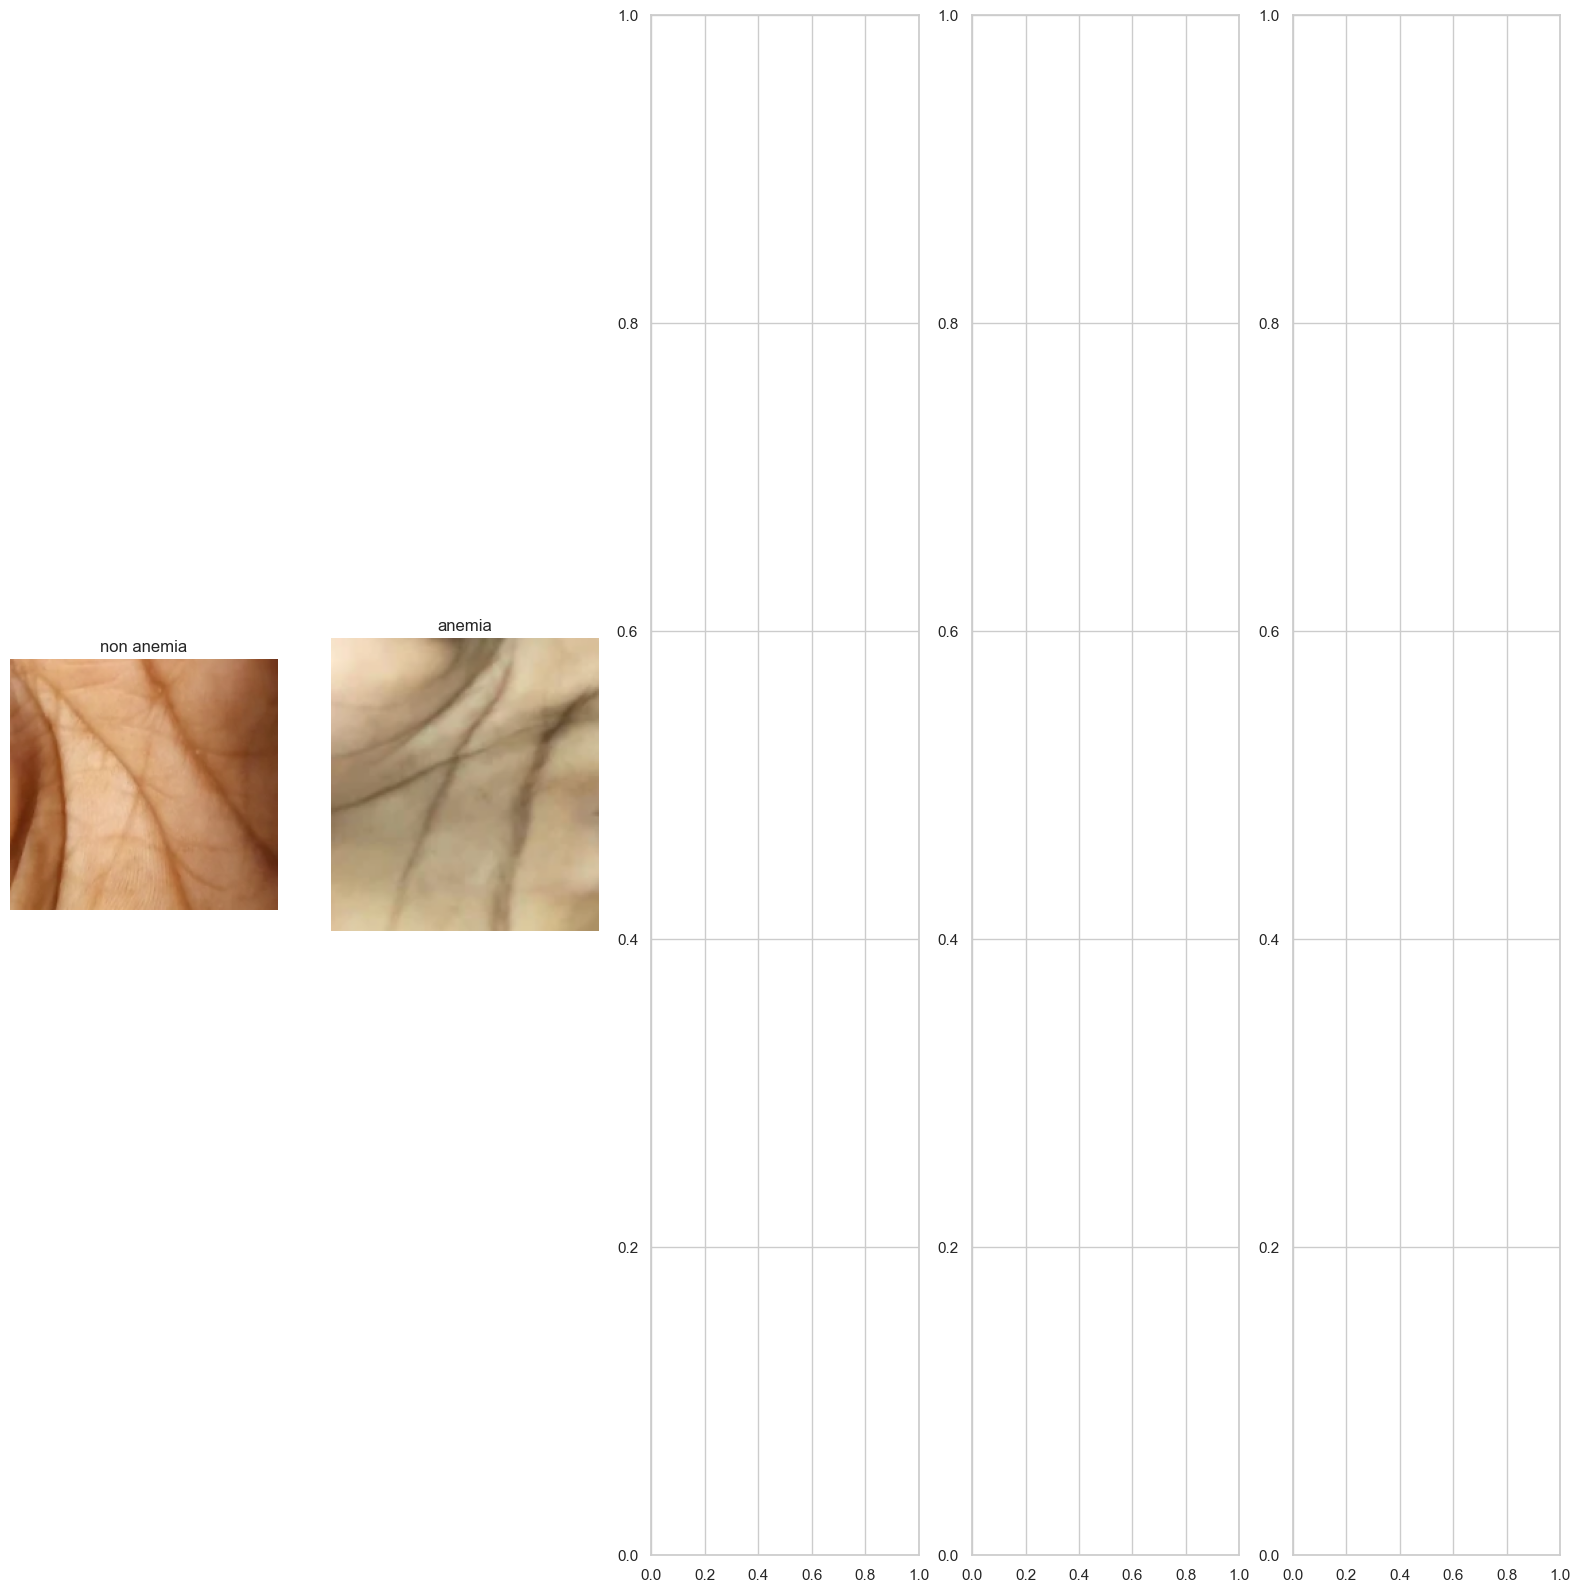

In [95]:
# Tentukan folder tempat dataset gambar diekstrak
dataset_dir = 'G:/My Drive/code/data aneimia'
  # Ganti dengan path ekstraksi datasetmu
# List folder (label) dalam dataset
labels = os.listdir(dataset_dir)

# Menampilkan beberapa gambar pertama dari dataset
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

# Loop untuk menampilkan gambar dari 5 label pertama
for i, label in enumerate(labels[:5]):  # Menampilkan 5 label pertama
    label_path = os.path.join(dataset_dir, label)

    # Menyaring hanya file gambar, bukan folder
    image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]

    if image_files:  # Jika ada file gambar dalam folder
        img_path = os.path.join(label_path, image_files[0])  # Mengambil gambar pertama
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label)

plt.show()

In [96]:
# Menghitung jumlah data per label
labels_list = []

# Menyusun daftar semua label berdasarkan gambar dalam folder
for label in labels:
    label_path = os.path.join(dataset_dir, label)
    image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    labels_list.extend([label] * len(image_files))  # Menambahkan label sesuai jumlah gambar

# Menghitung jumlah data per label
label_counts = pd.Series(labels_list).value_counts()

# Menampilkan jumlah data per label dalam bentuk teks
print("Total Jumlah Label:", len(label_counts))
print("Persebaran Data per Label:")
print(label_counts)

Total Jumlah Label: 2
Persebaran Data per Label:
non anemia    30
anemia        30
Name: count, dtype: int64


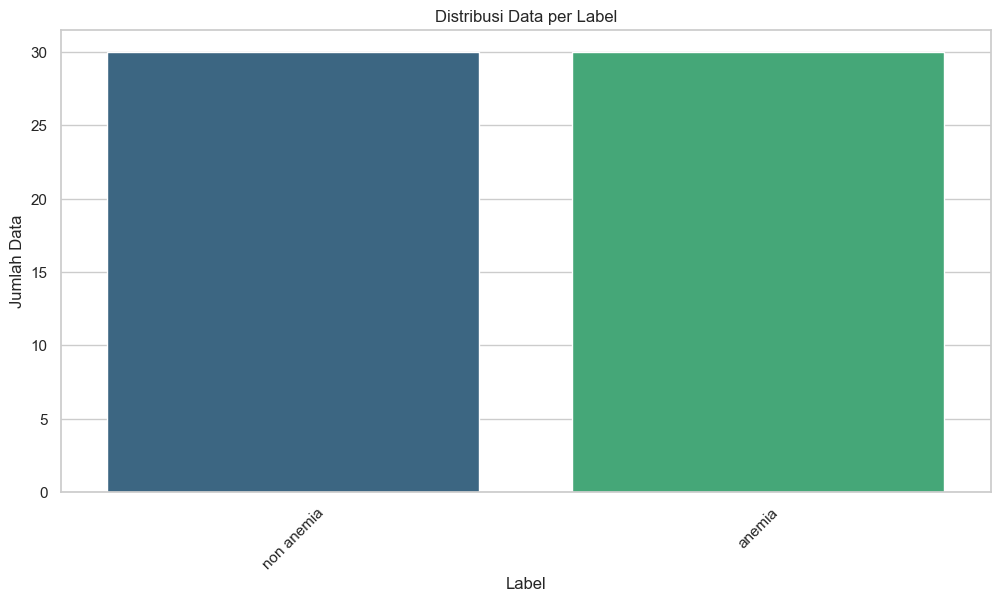

In [97]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot distribusi data per label
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Menambahkan label dan judul
plt.title("Distribusi Data per Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)  # Rotasi label sumbu X 45 derajat

# Menampilkan plot
plt.show()

### Data Preprocessing

#### Resize dan Normalisasi

In [98]:
from tqdm import tqdm

def resize_and_save_images(source_dir, target_dir, target_size=(224, 224)):
    # Kalau folder target belum ada, buat
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop semua folder label
    labels = os.listdir(source_dir)
    for label in tqdm(labels, desc='Resizing folders'):
        label_path = os.path.join(source_dir, label)
        target_label_path = os.path.join(target_dir, label)

        if not os.path.exists(target_label_path):
            os.makedirs(target_label_path)

        if os.path.isdir(label_path):  # Pastikan itu folder, bukan file
            images = os.listdir(label_path)
            for image_file in tqdm(images, desc=f'Resizing {label}', leave=False):
                if image_file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                    img_path = os.path.join(label_path, image_file)
                    img = Image.open(img_path).convert('RGB')  # Convert supaya tidak error mode
                    img_resized = img.resize(target_size)

                    save_path = os.path.join(target_label_path, image_file)
                    img_resized.save(save_path)

# Example usage:
source_dataset_dir = 'G:/My Drive/code/data aneimia'
target_dataset_dir = 'G:/My Drive/code/data anemia resizede'  # Folder hasil resize

resize_and_save_images(source_dataset_dir, target_dataset_dir, target_size=(224, 224))

Resizing folders: 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]


#### Data Augmentation

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset hasil resize
dataset_fix = 'G:/My Drive/code/data anemia resizede'

# Buat ImageDataGenerator + augmentasi + split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Train Generator
train_generator = datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator (augmentasi biasa hanya rescale)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 48 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


#### Split Dataset

In [100]:
# Buat 1 datagen untuk training dan validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.4  # 30% dibagi validation + test
)

# Train generator (70% data)
train_generator = datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Untuk validation/test, buat datagen baru tanpa augmentasi
test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5
)

# Validation generator (15% data)
val_generator = test_val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test generator (ambil validation lagi dengan shuffle=False untuk evaluasi final)
test_generator = test_val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Test set jangan di-shuffle
)


Found 36 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [101]:
print(f"Jumlah data training: {train_generator.samples}")
print(f"Jumlah data validation: {val_generator.samples}")
print(f"Jumlah data test: {test_generator.samples}")

Jumlah data training: 36
Jumlah data validation: 30
Jumlah data test: 30


## Modelling

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Inisialisasi model
model = Sequential()

# Layer Convolutional pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional kedua
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional keempat
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk menghindari overfitting

# Output Layer
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model.summary()

C:\Users\adyfjr\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,659 (2.50 MB)

 Trainable params: 654,659 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# EarlyStopping untuk menghentikan pelatihan lebih awal jika akurasi validasi tidak meningkat
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Memantau akurasi pada data validasi
    patience=5,               # Berhenti jika tidak ada peningkatan dalam 5 epoch berturut-turut
    min_delta=0.01,           # Peningkatan minimal yang dianggap sebagai peningkatan yang berarti
    mode='max',               # Menunggu peningkatan maksimum pada val_accuracy
    verbose=1,                # Menampilkan informasi ketika pelatihan dihentikan lebih awal
    restore_best_weights=True # Mengembalikan bobot terbaik berdasarkan val_accuracy
)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan akurasi validasi
model_checkpoint = ModelCheckpoint(
    'best_model.h5',         # Nama file untuk menyimpan model terbaik
    monitor='val_accuracy',  # Memantau akurasi pada data validasi
    save_best_only=True,     # Hanya menyimpan model jika val_accuracy meningkat
    mode='max',              # Menyimpan model ketika val_accuracy maksimum
    verbose=1                # Menampilkan informasi saat model disimpan
)

# ReduceLROnPlateau untuk mengurangi learning rate jika akurasi validasi stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Memantau loss pada data validasi
    factor=0.2,           # Mengurangi learning rate dengan faktor 0.2
    patience=5,           # Menunggu 5 epoch jika tidak ada penurunan val_loss
    min_lr=1e-6,          # Learning rate tidak boleh lebih kecil dari 1e-6
    verbose=1             # Menampilkan informasi ketika learning rate dikurangi
)



In [104]:
# Melatih model dengan callback yang sudah ditambahkan
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

C:\Users\adyfjr\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.2500 - loss: 1.0977
Epoch 1: val_accuracy improved from None to 0.50000, saving model to best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.2500 - loss: 1.0977 - val_accuracy: 0.5000 - val_loss: 1.0724 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4688 - loss: 1.0783
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4688 - loss: 1.0783 - val_accuracy: 0.5000 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4688 - loss: 1.0058
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4688 - loss: 1.0058 - val_accuracy: 0.5000 - val_loss: 0.8791 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.7500 - loss: 0.8075
Epoch 4: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7500 - loss: 0.8075 - val_accuracy: 0.5000 - val_loss: 0.8280 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/st

## Evaluasi dan Visualisasi

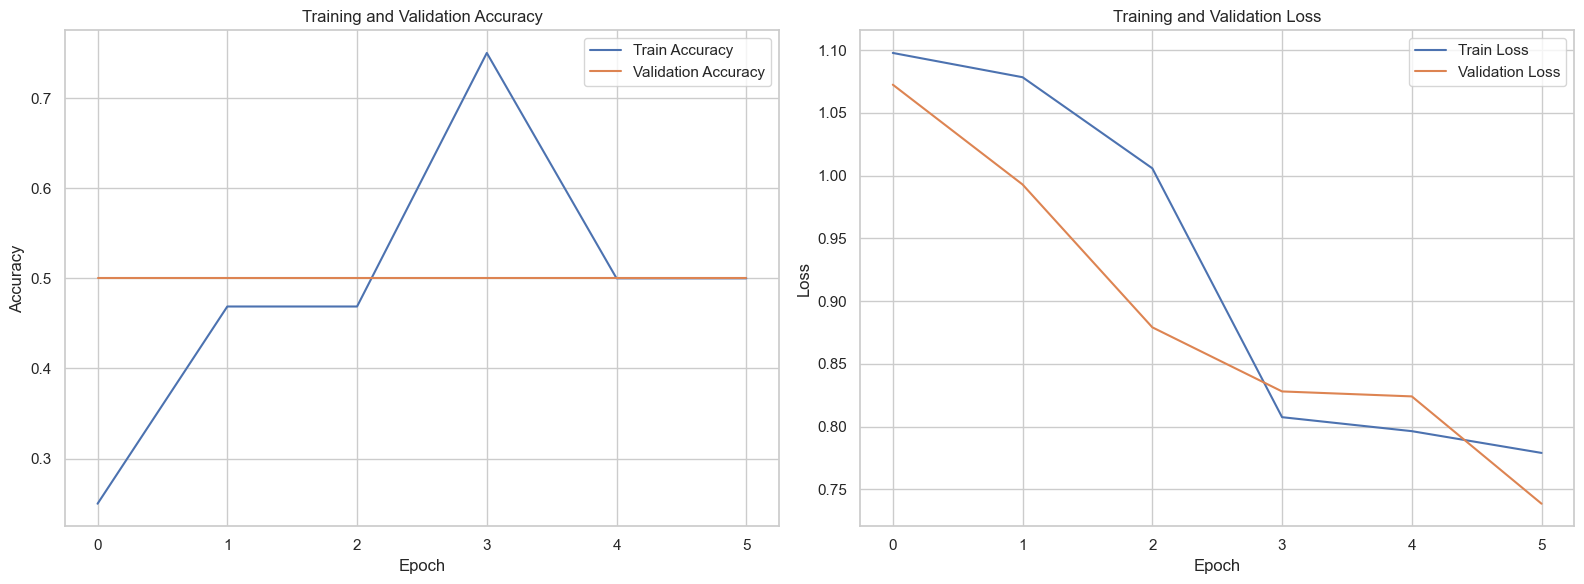

In [105]:
plt.figure(figsize=(16, 6))

# Subplot untuk Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [106]:
# Evaluasi akurasi di data test
test_loss, test_accuracy = model.evaluate(test_generator)
# Akurasi terakhir dari training dan validation
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_accuracy:.3f} = {train_accuracy*100:.0f}%")
print(f"Validation Accuracy: {val_accuracy:.3f} = {val_accuracy*100:.0f}%")
print(f"Test Accuracy: {test_accuracy:.3f} = {test_accuracy*100:.0f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 1.0724
Train Accuracy: 0.500 = 50%
Validation Accuracy: 0.500 = 50%
Test Accuracy: 0.500 = 50%


In [107]:
print(train_generator.class_indices)

{'anemia': 0, 'data aneimia': 1, 'non anemia': 2}


In [109]:
# Ambil y_true dan prediksi
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# AMBIL LABEL OTOMATIS DARI GENERATOR
# Ini akan memastikan jumlah target_names sesuai dengan jumlah kelas yang ditemukan generator
labels = list(test_generator.class_indices.keys())

# Tambahkan parameter 'labels' di dalam fungsi untuk membatasi evaluasi pada kelas yang ada
report = classification_report(
    y_true, 
    y_pred, 
    target_names=labels, 
    labels=np.unique(y_true), # Mengikuti kelas yang benar-benar ada di y_true
    output_dict=True
)

# Cetak hasil
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

print(f"Precision (Macro Avg): {precision:.3f} = {precision*100:.0f}%")
print(f"Recall (Macro Avg): {recall:.3f} = {recall*100:.0f}%")
print(f"F1 Score (Macro Avg): {f1_score:.3f} = {f1_score*100:.0f}%")

Precision (Macro Avg): 0.250 = 25%
Recall (Macro Avg): 0.500 = 50%
F1 Score (Macro Avg): 0.333 = 33%


C:\Users\adyfjr\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:2964: UserWarning: labels size, 2, does not match size of target_names, 3
  warnings.warn(
C:\Users\adyfjr\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\adyfjr\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\adyfjr\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarn

## Konversi Model

In [114]:
!pip install tensorflowjs

Defaulting to user installation because normal site-packages is not writeable


In [113]:
# 2. Import libraries
import tensorflow as tf
import tensorflowjs as tfjs
import os
import pathlib

# 3. Load model dari best_model.h5
model = tf.keras.models.load_model('best_model.h5')

# 4. Membuat folder submission kalau belum ada
os.makedirs('submission/tfjs_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/saved_model', exist_ok=True)

# 5. Convert ke TensorFlow.js
tfjs.converters.save_keras_model(model, 'submission/tfjs_model')

# 6. Convert ke SavedModel (.pb + variables)
tf.saved_model.save(model, 'submission/saved_model')

# 7. Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()

# Simpan model.tflite
tflite_model_file = pathlib.Path('submission/tflite/model.tflite')
tflite_model_file.write_bytes(tflite_model)

# 8. Simpan label.txt
# (buat file label.txt sesuai label di train_generator)

# Ambil label dari train_generator
labels = list(train_generator.class_indices.keys())

# Simpan ke label.txt
with open('submission/tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

print("✅ Semua model sudah berhasil dikonversi!")

AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
!zip -r /content/submission.zip /content/submission

  adding: content/submission/ (stored 0%)
  adding: content/submission/tflite/ (stored 0%)
  adding: content/submission/tflite/model.tflite (deflated 74%)
  adding: content/submission/tflite/label.txt (deflated 37%)
  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: content/submission/tfjs_model/model.json (deflated 86%)
  adding: content/submission/saved_model/ (stored 0%)
  adding: content/submission/saved_model/variables/ (stored 0%)
  adding: content/submission/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/submission/saved_model/variables/variables.index (deflated 55%)
  adding: content/submission/saved_model/saved_model.pb (deflated 85%)
  adding: content/submission/saved_model/assets/ (stored 0%)
  adding: content/submission/saved_model/fingerprint.pb (stored 0%)


In [ ]:
!cp /content/submission.zip /content/drive/MyDrive/

## Inference (Optional)

In [ ]:
import tensorflow as tf
from keras.layers import TFSMLayer
import numpy as np
from tensorflow.keras.preprocessing import image

# Load model dari SavedModel
model = TFSMLayer('/content/submission/saved_model', call_endpoint='serving_default')

# Load labels
with open('/content/submission/tflite/label.txt', 'r') as f:
    labels = f.read().splitlines()

# Function untuk preprocessing gambar
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension
    return img_array

# Path gambar (dari Google Drive)
img_paths = [
    '/content/drive/MyDrive/abimanyuu.jpg',
    '/content/drive/MyDrive/gatott.jpg',
    '/content/drive/MyDrive/petruk.jpg'
]

# Prediksi semua gambar
for img_path in img_paths:
    img_array = preprocess_image(img_path)
    preds_dict = model(img_array)      # hasilnya dict
    preds = preds_dict['output_0'].numpy()  # ambil tensor dari dict, lalu numpy

    # Top-5 predictions
    top5_indices = preds[0].argsort()[-5:][::-1]
    top5_labels = [(labels[i], preds[0][i] * 100) for i in top5_indices]

    print(f"Prediksi untuk gambar: {img_path}")
    for label, prob in top5_labels:
        print(f"- {label}: {prob:.2f}%")
    print()


Prediksi untuk gambar: /content/drive/MyDrive/abimanyuu.jpg
- abimanyu: 99.79%
- bagong: 0.16%
- durna: 0.03%
- semar: 0.01%
- bima: 0.00%

Prediksi untuk gambar: /content/drive/MyDrive/gatott.jpg
- gatotkaca: 65.30%
- bima: 13.44%
- abimanyu: 8.92%
- karna: 5.67%
- bagong: 2.25%

Prediksi untuk gambar: /content/drive/MyDrive/petruk.jpg
- petruk: 99.45%
- gareng: 0.52%
- bima: 0.03%
- gatotkaca: 0.00%
- bagong: 0.00%

